In [1]:
%matplotlib inline

In [2]:
#importing necessary libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from statsbombpy import sb
from mplsoccer import Pitch, Sbopen, VerticalPitch
import seaborn as sns

In [3]:
# getting the df of the 64 matches played in the WC
wc22=sb.matches(competition_id=43,season_id=106)

In [4]:
#declare mplsoccer parser
parser = Sbopen()

In [5]:
# list of match_ids in the wc
match_ids = wc22['match_id'].to_list()

### To know the number of matches each country played

In [11]:
# concatenate the two columns into a single series
combined_series = pd.concat([wc22['home_team'], wc22['away_team']])

### Iterating through the tournament for Danger Passes
Danger passes are passes made within the 15 seconds leading up to a shot

In [8]:
#declare an empty dataframe
danger_passes = pd.DataFrame()
for idx in match_ids:
    #open the event data from this game
    df = parser.event(idx)[0]
    for period in [1, 2]:
        #keep only accurate passe s that were not set pieces in this period
        mask_pass = (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
        #keep only necessary columns
        passes = df.loc[mask_pass, ["x", "y", "minute", "second", "player_name","possession_team_name"]]
        #keep only Shots in this period
        mask_shot = (df.type_name == "Shot") & (df.period == period)
        #keep only necessary columns
        shots = df.loc[mask_shot, ["minute", "second"]]
        #convert time to seconds
        shot_times = shots['minute']*60+shots['second']
        shot_window = 15
        #find starts of the window
        shot_start = shot_times - shot_window
        #condition to avoid negative shot starts
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        #convert to seconds
        pass_times = passes['minute']*60+passes['second']
        #check if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        #keep only danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        #concatenate dataframe with a previous one to keep danger passes from the whole tournament
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)

In [12]:
# Arranging team names in alphabetical order
danger_passes=danger_passes.sort_values('possession_team_name')

### Generating the Plot

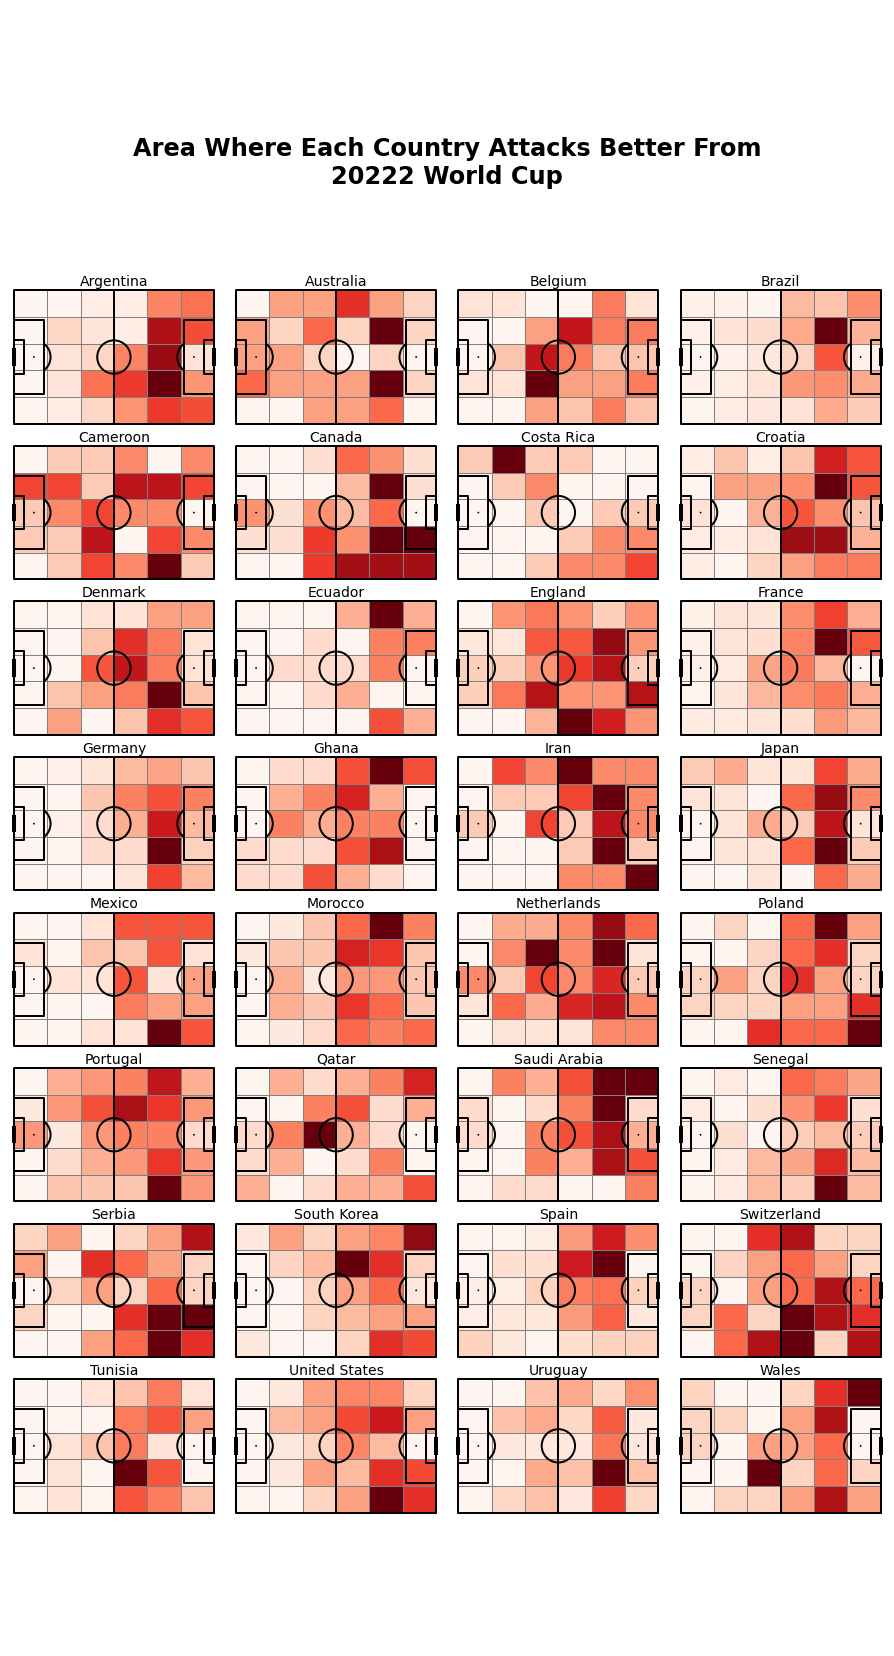

In [23]:
#get the list of teams
names = danger_passes['possession_team_name'].unique()

pitch = Pitch(line_zorder=2, line_color='black')
fig, axs = pitch.grid(ncols = 4, nrows = 8,figheight=24, axis=False)

#for each team name
for name, ax in zip(names, axs['pitch'].flat[:len(names)]):
    #put team name over the plot
    ax.text(60, -5, name,ha='center',va='center',fontsize=14)
    #take only passes by this team
    team_df = danger_passes.loc[danger_passes["possession_team_name"] == name]
    #get the 2D histogram 
    bin_statistic = pitch.bin_statistic(team_df.x, team_df.y, statistic='count', bins=(6, 5), normalize=False)
    #normalize by number of total games played by each team
    bin_statistic["statistic"] = bin_statistic["statistic"]/combined_series.tolist().count(name)
    #make a heatmap
    pcm = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax)

fig.suptitle('Passes Leading up to Shots\n20222 World Cup', y=0.9,fontsize= 24,fontweight='bold')
plt.savefig("wc22_dangerpass",bbox_figure="tight",dpi=300)    
plt.show()

### Dividing the plot into 2 to make it more viewable

In [24]:
# Countries divided into 2 alphabetically
first_set=names[0:16]
second_set=names[16:32]

In [25]:
# The dfs of lost passes
df1=danger_passes[danger_passes['possession_team_name'].isin(first_set)]
df2=danger_passes[danger_passes['possession_team_name'].isin(second_set)]

#### First set of teams

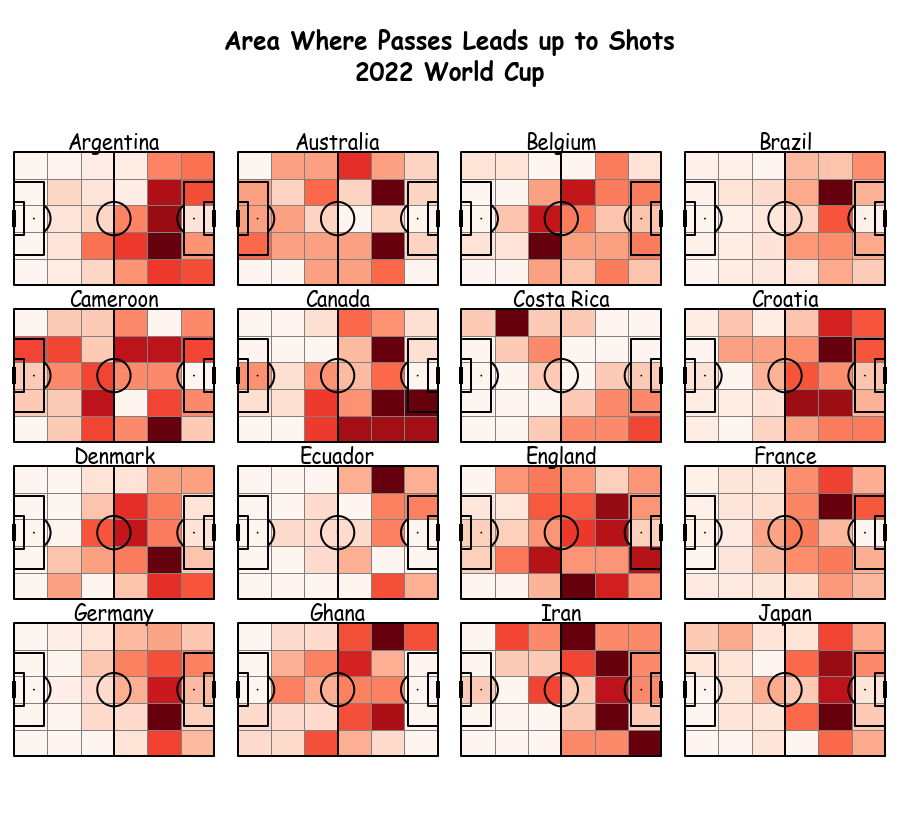

In [30]:
#get the list of teams
names = df1['possession_team_name'].unique()

pitch = Pitch(line_zorder=2, line_color='black')
fig, axs = pitch.grid(ncols = 4, nrows = 4,figheight=12, axis=False)

#for each team name
for name, ax in zip(names, axs['pitch'].flat[:len(names)]):
    #put team name over the plot
    ax.text(60, -5, name,ha='center',va='center',fontdict={'fontsize':20,'fontfamily':'Comic Sans MS'})
    #take only passes by this team
    team_df = df1.loc[df1["possession_team_name"] == name]
    #get the 2D histogram 
    bin_statistic = pitch.bin_statistic(team_df.x, team_df.y, statistic='count', bins=(6, 5), normalize=False)
    #normalize by number of total passes by each team
    bin_statistic["statistic"] = bin_statistic["statistic"]
    #make a heatmap
    pcm = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax)

fig.suptitle('Area Where Passes Leads up to Shots\n2022 World Cup', y=0.95,fontsize= 24,fontfamily='Comic Sans MS',fontweight='bold')
plt.savefig("wc22_dangerpass1",bbox_figure="tight",dpi=300)    
plt.show()

#### Second set of teams

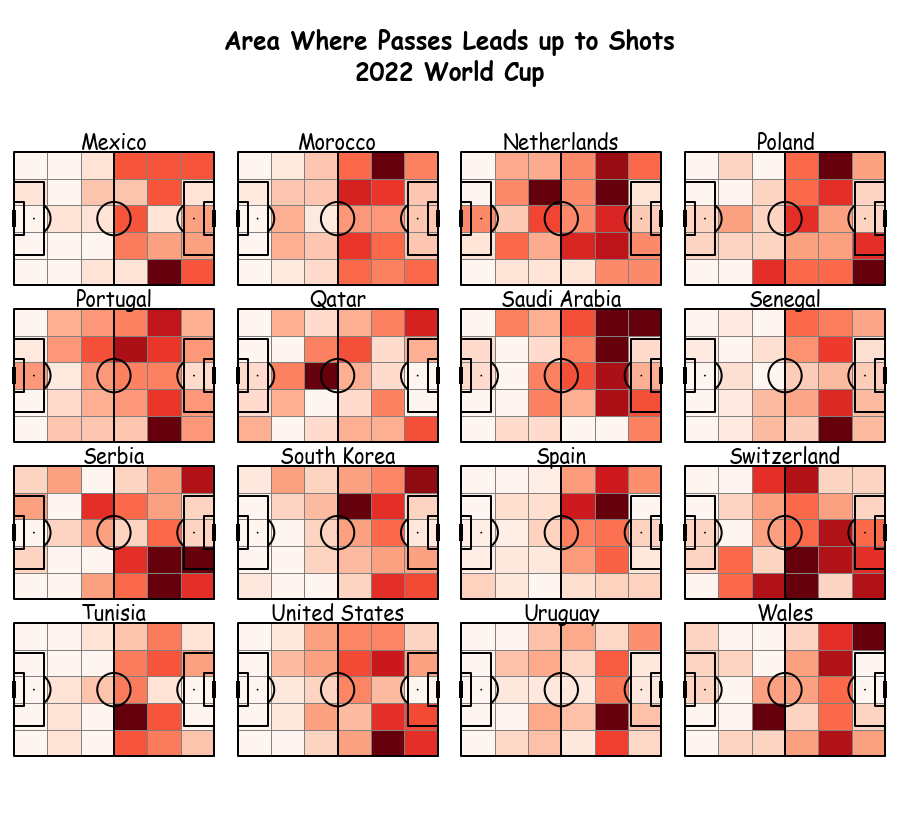

In [31]:
#get the list of teams
names = df2['possession_team_name'].unique()

pitch = Pitch(line_zorder=2, line_color='black')
fig, axs = pitch.grid(ncols = 4, nrows = 4,figheight=12, axis=False)

#for each team name
for name, ax in zip(names, axs['pitch'].flat[:len(names)]):
    #put team name over the plot
    ax.text(60, -5, name,ha='center',va='center',fontdict={'fontsize':20,'fontfamily':'Comic Sans MS'})
    #take only passes by this team
    team_df = df2.loc[df2["possession_team_name"] == name]
    #get the 2D histogram 
    bin_statistic = pitch.bin_statistic(team_df.x, team_df.y, statistic='count', bins=(6, 5), normalize=False)
    #normalize by number of total passes by each team
    bin_statistic["statistic"] = bin_statistic["statistic"]
    #make a heatmap
    pcm = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax)

fig.suptitle('Area Where Passes Leads up to Shots\n2022 World Cup', y=0.95,fontsize= 24,fontfamily='Comic Sans MS',fontweight='bold')
plt.savefig("wc22_dangerpass2",bbox_figure="tight",dpi=300)    
plt.show()